**Toy examples**

In this part of the practical session, you will play with some toy data to better understand the classification algorithms seen this morning.

Please answer all questions

**Deadline**: Upload this notebook, the one about Emotion Recognition and the answers to the theoretical questions to E-Campus. Please verify the exact deadline on E-Campus.

Let's first load the needed packages.

In [1]:
import numpy as np
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt  # for plots
from matplotlib.colors import ListedColormap
from matplotlib import rc

import seaborn as sns
from sklearn.linear_model import LogisticRegression, LinearRegression
from sklearn.preprocessing import OneHotEncoder
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from sklearn.multiclass import OneVsRestClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import confusion_matrix, accuracy_score
import time

%matplotlib inline
np.random.seed(seed=666)

Here, we define some functions useful for generating and plotting the data

In [2]:
def gaussian_data_generation(n, mean, cov, noise_std):
   # create data which follows a multivariate Gaussian distribution
   # a white (Gaussian) noise is then added to the data

    assert cov.shape[0] == cov.shape[1], "Please use only square covariance matrix"
    assert len(mean) == cov.shape[0], "the dimension of the mean should be equal to the dimension of the covariance matrix"

    X = np.random.multivariate_normal(mean, cov, n) # actual data
    X = X + np.random.multivariate_normal(np.zeros(len(mean)), noise_std ** 2 *np.eye(len(mean)), n)  # we add white noise to the data

    return X

def frontiere(f, X, y, step=50):
    # decision boundary of classifier f
    # construct cmap

    min_tot = np.min(X)
    max_tot = np.max(X)
    delta = (max_tot - min_tot) / step
    xx, yy = np.meshgrid(np.arange(min_tot, max_tot, delta),
                         np.arange(min_tot, max_tot, delta))
    z = np.array([f(vec) for vec in np.c_[xx.ravel(), yy.ravel()]])
    z = z.reshape(xx.shape)
    labels = np.unique(z)
    color_blind_list = sns.color_palette("colorblind", labels.shape[0])
    sns.set_palette(color_blind_list)
    my_cmap = ListedColormap(color_blind_list)
    plt.imshow(z, origin='lower', extent=[min_tot, max_tot, min_tot, max_tot],
               interpolation="mitchell", alpha=0.80, cmap=my_cmap)

    ax = plt.gca()
    cbar = plt.colorbar(ticks=labels)
    cbar.ax.set_yticklabels(labels)

    k = np.unique(y).shape[0]
    color_blind_list = sns.color_palette("colorblind", k)
    for i, label in enumerate(y):
        plt.scatter(X[i, 0], X[i, 1], c=[color_blind_list[int(y[i])]],
                    s=80, marker=symlist[int(label)])
    plt.ylim([min_tot, max_tot])
    plt.xlim([min_tot, max_tot])
    ax.get_yaxis().set_ticks([])
    ax.get_xaxis().set_ticks([])

def class_int_round(z, n_class):
    # rounding needed to go from real to integer values
    output = np.round(z).astype(int)
    if isinstance(z, np.ndarray):
        j = z < 0
        output[j] = 0
        k = z > n_class - 1
        output[k] = n_class - 1
    else:
        if output < 0:
            output = 0
        else:
            if output > n_class - 1:
                output = n_class - 1
    return output

The next function is the one you will use to crete the toy data. You can choose among three scenarios: 2, 3 or 4 classes. Each class is composed of 2D points sampled from a multivariate Gaussian distribution. You can choose the number of samples, average and covariance matrix for each class.

In [3]:
def generate_scenario(n_classes=3):

    if n_classes == 2:
        # Example with 2 classes
        n_0=80
        mean_0 = [0, 0]
        cov_0 = np.array([[1, 0.1], [0.1, 0.9]])
        X_0=gaussian_data_generation(n_0, mean_0, cov_0, 0.1)
        y_0=np.zeros(n_0)

        n_1=80
        mean_1 = [3, 2]
        cov_1 = np.array([[0.1, 0], [0, 0.5]])
        X_1=gaussian_data_generation(n_1, mean_1, cov_1, 0.1)
        y_1=np.ones(n_1)

        X=np.concatenate((X_0,X_1))
        y=np.concatenate((y_0,y_1))

    elif n_classes == 3:
        # Example with 3 classes
        n_0=80
        mean_0 = [0, 0]
        cov_0 = np.array([[1, 0.1], [0.1, 0.9]])
        X_0=gaussian_data_generation(n_0, mean_0, cov_0, 0.1)
        y_0=np.zeros(n_0)

        n_1=80
        mean_1 = [2, 2]
        cov_1 = np.array([[0.1, 0], [0, 0.5]])
        X_1=gaussian_data_generation(n_1, mean_1, cov_1, 0.1)
        y_1=np.ones(n_1)

        n_2=80
        mean_2 = [3, 3]
        cov_2 = np.array([[0.5, 0.1], [0.1, 1]])
        X_2=gaussian_data_generation(n_2, mean_2, cov_2, 0.1)
        y_2=2*np.ones(n_2)

        X=np.concatenate((X_0,X_1,X_2))
        y=np.concatenate((y_0,y_1,y_2))
    elif n_classes == 4:
        # Example with 4 classes
        n_0=80
        mean_0 = [0, 0]
        cov_0 = np.array([[1, 0.1], [0.1, 0.9]])
        X_0=gaussian_data_generation(n_0, mean_0, cov_0, 0.1)
        y_0=np.zeros(n_0)

        n_1=80
        mean_1 = [3, 3]
        cov_1 = np.array([[0.1, 0], [0, 0.5]])
        X_1=gaussian_data_generation(n_1, mean_1, cov_1, 0.1)
        y_1=np.ones(n_1)

        n_2=80
        mean_2 = [0, 3]
        cov_2 = np.array([[0.5, 0.1], [0.1, 1]])
        X_2=gaussian_data_generation(n_2, mean_2, cov_2, 0.1)
        y_2=2*np.ones(n_2)

        n_3=80
        mean_3 = [3, 0]
        cov_3 = np.array([[0.9, 0.15], [0.15, 0.8]])
        X_3=gaussian_data_generation(n_3, mean_3, cov_3, 0.1)
        y_3=3*np.ones(n_3)

        X=np.concatenate((X_0,X_1,X_2,X_3))
        y=np.concatenate((y_0,y_1,y_2,y_3))

    return X, y

Let's choose a scenario and generate some data

In [4]:
######## PARAMETER TO CHOOSE THE SCENARIO (number of classes) #######
n_classes=3
#####################################################################

X, y = generate_scenario(n_classes)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

In [5]:
print(y)

[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 2. 2. 2. 2. 2. 2. 2. 2.
 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2.
 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2.
 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2.]


Let's plot the data

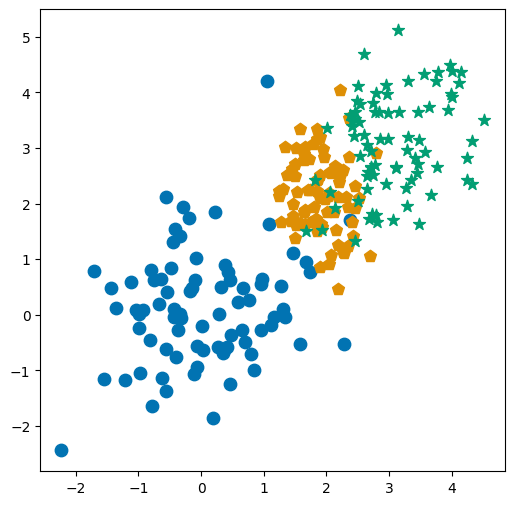

In [6]:
fig1 = plt.figure(figsize=(6, 6))
ax = plt.gca()
min_tot = np.min(X)
max_tot = np.max(X)
symlist = ['o', 'p', '*', 's', '+', 'x', 'D', 'v', '-', '^']
k = np.unique(y).shape[0]
color_blind_list = sns.color_palette("colorblind", k)
for i, label in enumerate(y):
    plt.scatter(X[i, 0], X[i, 1], c=[color_blind_list[int(y[i])]],
                s=80, marker=symlist[int(label)])
#ax.get_yaxis().set_ticks([])
#ax.get_xaxis().set_ticks([])

As first classifier, we can use a simple linear regression where we  transform in integers the predictions.

 **Question**: look at the function 'class_int_round'. Explain what it does.

This function takes an array with real values and a number of classes. It will then round the values in the array to integers. After that, it will take all values in the array below 0 and attribute 0 to them. Similarly, it will take values above n_classes - 1 and attribute n_classes - 1 to them.

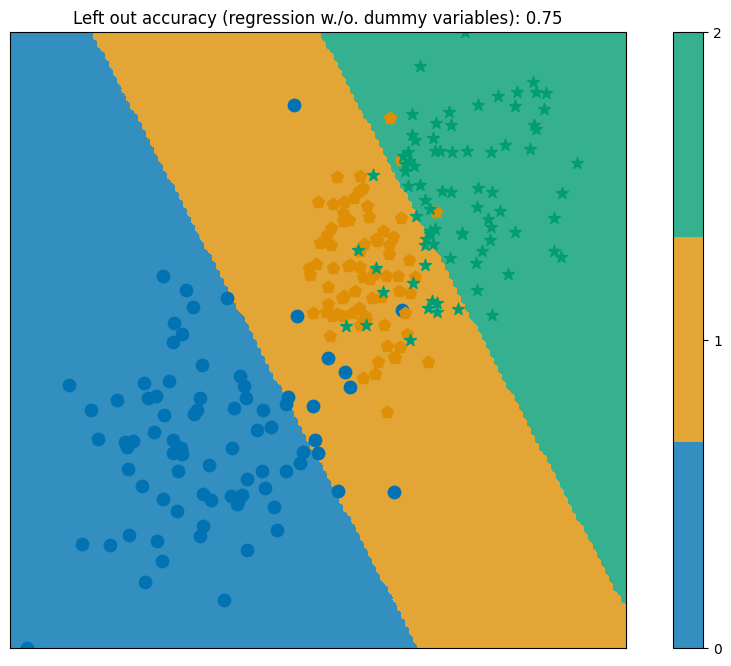

In [7]:
##############################################################################
# Naive linear regression on raw observations
##############################################################################

resolution_param = 150  # 500 for nice plotting, 50 for fast version
regr = LinearRegression()
regr.fit(X_train, y_train)
y_pred_test = class_int_round(regr.predict(X_test), n_classes)

# Plotting part
fig0 = plt.figure(figsize=(12, 8))
title = "Left out accuracy (regression w./o. dummy variables)" + \
        ": {:.2f}".format(accuracy_score(y_test, y_pred_test))
plt.title(title)

def f(xx):
    """Classifier"""
    return class_int_round(regr.predict(xx.reshape(1, -1)), n_classes)
frontiere(f, X, y, step=resolution_param)

plt.show()

Instead of using this simple strategy, we can also use a *OneHotEncoder*.

**Question**: Do you see any difference in the resulting decision boundaries ? Which is the best strategy in your opinion ? Why ?

Surprisingly, the new decision boundary (accuracy of 0.68) has worsen in comparison to the previous one (accuracy of 0.75). This is mainly because, although the boundary improved the accuracy in classifying the blue and green dots, the yellow dots are not well classified.  

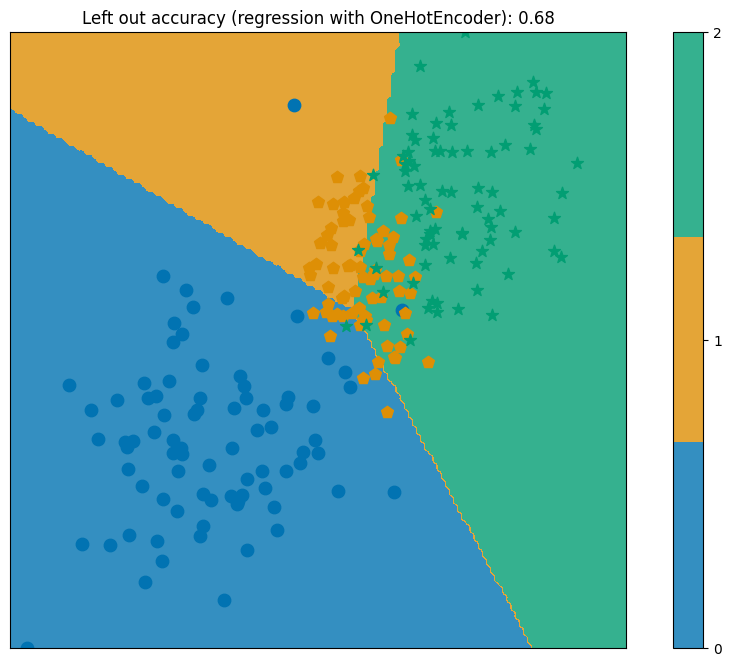

In [13]:
##############################################################################
# Naive linear regression on dummy variables (OneHotEncoder)
##############################################################################
resolution_param = 150
enc = OneHotEncoder(categories='auto')
enc.fit(y_train.reshape(-1, 1))
Y = enc.transform(y_train.reshape(-1, 1)).toarray()
regr_multi = LinearRegression()
regr_multi.fit(X_train, Y)
proba_vector_test = regr_multi.predict(X_test)
y_pred_test = class_int_round(regr.predict(X_test), n_classes)

# performance evaluation on new dataset
y_pred_test = np.argmax(proba_vector_test, axis=1)
title = "Left out accuracy (regression with OneHotEncoder)" + \
        ": {:.2f}".format(accuracy_score(y_test, y_pred_test))

# Plotting part
fig1 = plt.figure(figsize=(12, 8))
plt.title(title)


def f(xx):
    """Classifier"""
    return np.argmax(regr_multi.predict(xx.reshape(1, -1)))
frontiere(f, X, y, step=resolution_param)

plt.show()

Let's use the other strategies seen this morning.

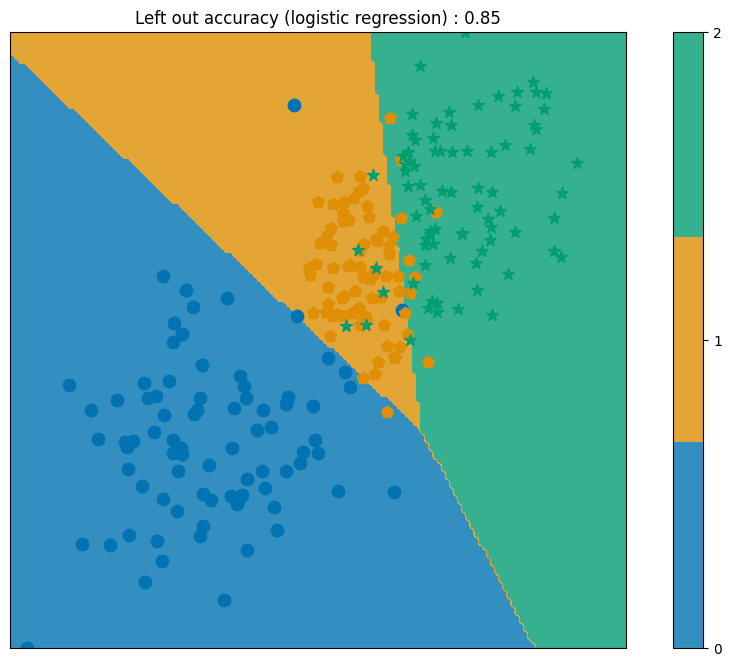

In [14]:
##############################################################################
# Logistic regression
##############################################################################
resolution_param = 150
#clf = LogisticRegression(solver='lbfgs',multi_class='ovr') # you can also try multi_class='multinomial',
clf = OneVsRestClassifier(LogisticRegression(solver='lbfgs')) # or use ,multi_class='ovr' in previous versions
clf.fit(X_train, y_train)
y_logit_test = clf.predict(X_test)
title = "Left out accuracy (logistic regression) " + \
        ": {:.2f}".format(accuracy_score(y_test, y_logit_test))
fig2 = plt.figure(figsize=(12, 8))
plt.title(title)


def f(xx):
    """Classifier"""
    return int(clf.predict(xx.reshape(1, -1))[0])
frontiere(f, X, y, step=resolution_param)

plt.show()

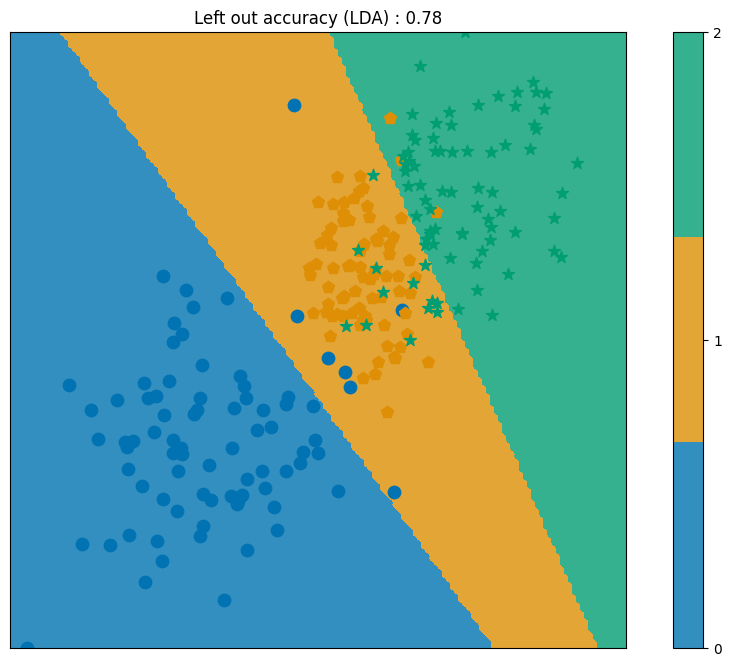

In [15]:
##############################################################################
# LDA
##############################################################################
resolution_param = 150
clf_LDA = LinearDiscriminantAnalysis()
clf_LDA.fit(X_train, y_train)
y_LDA_test = clf_LDA.predict(X_test)

title = "Left out accuracy (LDA) " + \
        ": {:.2f}".format(accuracy_score(y_test, y_LDA_test))
fig2 = plt.figure(figsize=(12, 8))
plt.title(title)


def f(xx):
    """Classifier"""
    return int(clf_LDA.predict(xx.reshape(1, -1))[0])
frontiere(f, X, y, step=resolution_param)

plt.show()

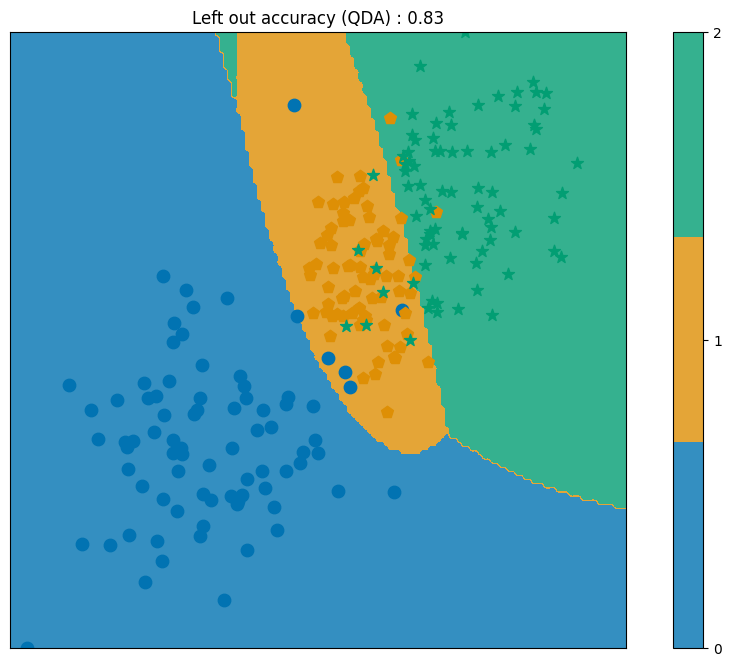

In [16]:
##############################################################################
# QDA
##############################################################################
resolution_param = 150
clf_QDA = QuadraticDiscriminantAnalysis()
clf_QDA.fit(X_train, y_train)
y_QDA_test = clf_QDA.predict(X_test)
title = "Left out accuracy (QDA) " + \
        ": {:.2f}".format(accuracy_score(y_test, y_QDA_test))
fig2 = plt.figure(figsize=(12, 8))
plt.title(title)


def f(xx):
    """Classifier"""
    return int(clf_QDA.predict(xx.reshape(1, -1))[0])
frontiere(f, X, y, step=resolution_param)

plt.show()

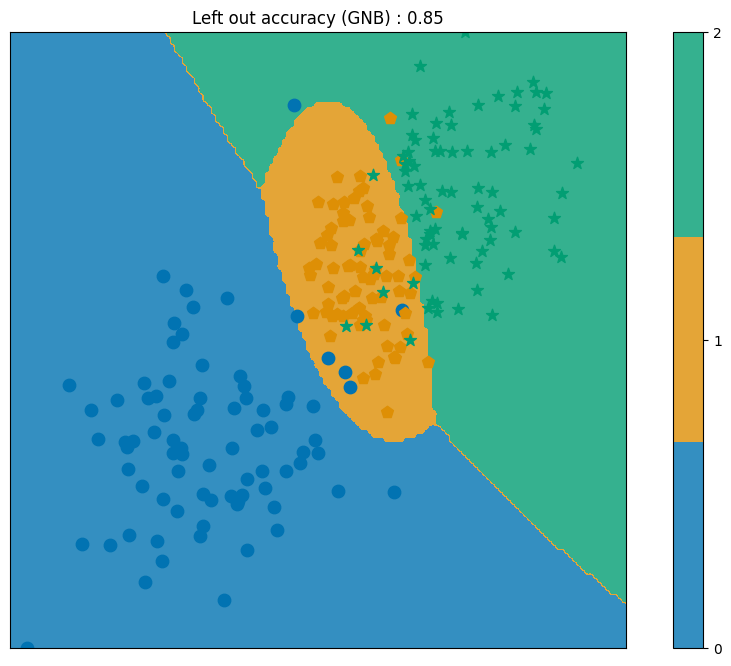

In [17]:
##############################################################################
# Naive Bayes
##############################################################################
resolution_param = 150
clf_GNB = GaussianNB()
clf_GNB.fit(X_train, y_train)

y_test_GNB = clf_GNB.predict(X_test)

title = "Left out accuracy (GNB) " + \
        ": {:.2f}".format(accuracy_score(y_test, y_test_GNB))
fig2 = plt.figure(figsize=(12, 8))
plt.title(title)


def f(xx):
    """Classifier"""
    return int(clf_GNB.predict(xx.reshape(1, -1))[0])
frontiere(f, X, y, step=resolution_param)

plt.show()

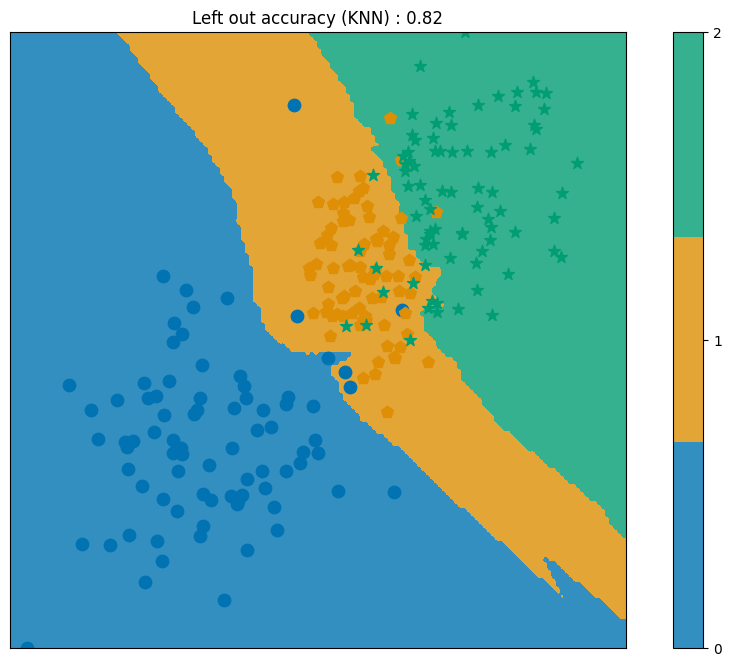

In [18]:
##############################################################################
# KNN
##############################################################################
resolution_param = 150
clf_KNN = KNeighborsClassifier()
clf_KNN.n_neighbors=5

clf_KNN.fit(X_train, y_train)
y_KNN_test = clf_KNN.predict(X_test)

title = "Left out accuracy (KNN) " + \
        ": {:.2f}".format(accuracy_score(y_test, y_KNN_test))
fig2 = plt.figure(figsize=(12, 8))
plt.title(title)

def f(xx):
    """Classifier"""
    return int(clf_KNN.predict(xx.reshape(1, -1))[0])
frontiere(f, X, y, step=resolution_param)

plt.show()

**Questions**:


*   Describe the decision boundaries of the methods. Are all linear ?

1) **Simple linear regression:** Naturally, the resulting boundaries are linear. The three classes are delimitated by parallel lines, as there is a single linear equation responsible for the classification of the data. One consequence of that is that points classified as 0 will always be farther from points classified as 2 than points classified as 1.


2) **Linear regression with One Hot Encoder:** The resulting boundaries are still linear. However, now the boundaries are not parallel lines, instead being 3 lines with an intersection. A consequence of this is that the 3 class regions are now directly connected to each other.

3) **Logistic regression**: The resulting boundaries are still non-parallel lines. However, the classification worked much better than in the previous case, as this method is much more appropriate for dealing with classification than linear regressions.

4) **Linear Discriminant Analysis:** The resulting boundaries are still non-parallel lines. However, it is not clear if there are connections between class 0 and class 2 regions, of if they are always separated by class 1.

5) **Quadratic Discriminant Analysis:** This time, the resulting boundaries are parabolas, and there are connections between all class regions.

6) **Gaussian Naïve Bayes:** The resulting boundaries are non-linear. There are connections between all class regions.

7) **K-Nearest Neighbors:** The resulting boundaries are chaotic and irregular. This method does not find a clear function for the boundaries and tends to be sensitive to noise, although a great advantage is its flexibility and adaptability.

*   Using the following code, compare the computational time and the test accuracy of the different methods in the three scenarios. Comment the results.
* (Optional) If you change the number of samples per class (both training and test), do the results vary ?



In [25]:
time_start = time.perf_counter()
resolution_param = 150  # 500 for nice plotting, 50 for fast version
regr = LinearRegression()
regr.fit(X_train, y_train)
y_pred_test = class_int_round(regr.predict(X_test), n_classes)

time_elapsed = (time.perf_counter() - time_start)
print('Computational time:', "%.2f" %time_elapsed, 's ; Test accuracy simple linear regression', "%.2f" %accuracy_score(y_test, y_pred_test))

Computational time: 0.00 s ; Test accuracy simple linear regression 0.75


In [29]:
time_start = time.perf_counter()
resolution_param = 150
enc = OneHotEncoder(categories='auto')
enc.fit(y_train.reshape(-1, 1))
Y = enc.transform(y_train.reshape(-1, 1)).toarray()
regr_multi = LinearRegression()
regr_multi.fit(X_train, Y)

proba_vector_test = regr_multi.predict(X_test)
y_pred_test = class_int_round(regr.predict(X_test), n_classes)
y_pred_test = np.argmax(proba_vector_test, axis=1)
time_elapsed = (time.perf_counter() - time_start)
print('Computational time:', "%.2f" %time_elapsed, 's ; Test accuracy regression with OneHotEncoder', "%.2f" %accuracy_score(y_test, y_pred_test))

Computational time: 0.04 s ; Test accuracy regression with OneHotEncoder 0.68


In [30]:
time_start = time.perf_counter()

resolution_param = 150
clf_LDA = LinearDiscriminantAnalysis()
clf_LDA.fit(X_train, y_train)
y_LDA_test = clf_LDA.predict(X_test)

time_elapsed = (time.perf_counter() - time_start)

print('Computational time:', "%.2f" %time_elapsed, 's ; LDA', "%.2f" %accuracy_score(y_test, y_LDA_test))

Computational time: 0.01 s ; LDA 0.78


In [32]:
time_start = time.perf_counter()

resolution_param = 150
clf_QDA = QuadraticDiscriminantAnalysis()
clf_QDA.fit(X_train, y_train)
y_QDA_test = clf_QDA.predict(X_test)


time_elapsed = (time.perf_counter() - time_start)

print('Computational time:', "%.2f" %time_elapsed, 's ; QDA', "%.2f" %accuracy_score(y_test, y_QDA_test))


Computational time: 0.00 s ; QDA 0.83


In [33]:
time_start = time.perf_counter()

clf_GNB = GaussianNB()
clf_GNB.fit(X_train, y_train)

y_test_GNB = clf_GNB.predict(X_test)

print('Computational time:', "%.2f" %time_elapsed, 's ; GNB', "%.2f" %accuracy_score(y_test, y_test_GNB))


Computational time: 0.00 s ; GNB 0.85


In [21]:
# example using KNN
time_start = time.perf_counter()
clf_KNN.fit(X_train, y_train)
y_KNN_test = clf_KNN.predict(X_test)
time_elapsed = (time.perf_counter() - time_start)
print('Computational time:', "%.2f" %time_elapsed, 's ; Test accuracy KNN', "%.2f" %accuracy_score(y_test, y_KNN_test))

Computational time: 0.01 s ; Test accuracy KNN 0.82
